# The Utility-Fairness Tradeoff

In this post, I'll be taking a dive into the capabilities of `themis_ml` as a tool to measure and mitigate discriminatory patterns in training data and the predictions made by machine learning algorithms trained for the purposes of socially sensitive decision processes.

The overall goal of this research is to come up with a reasonable way to
think about how to make machine learning algorithms more fair. While the
mathematical formalization of fairness is not sufficient to solve the
problem of discrimination, our ability to understand and articulate
what it means for an algorithm to be fair is a step in the right direction.

Since the "discrimination" is an value-laden term in this context, I'll
refer to the opposite of fairness as *potential discrimination* (PD)
since the any socially biased patterns we'll be measuring in the
training data did not necessarily arise from discriminatory processes.

I'll be using the German Credit data, which consists of ~1000 loan
application containing roughly 20 input variables (including `foreign_worker`, `housing`, and `credit_history`) and 1 binary target variable `credit_risk`, which is either `good` or `bad`.

In the context of a `good/bad credit_risk` binary predict task and an
explicit definition of fairness, our objectives will be to:

1. Measure the degree of discrimination in the dataset with respect to some
   discrimination metric and protected class.
2. Establish a baseline performance level with respect to utility and fairness
   metrics with models trained on a fairness-unaware machine learning pipeline.
3. Measure and compare the baseline metrics with fairness aware models.

# Load Data

In [1]:
from themis_ml import datasets
from themis_ml.datasets.german_credit_data_map import \
    preprocess_german_credit_data
from themis_ml.metrics import mean_difference, normalized_mean_difference

In [2]:
german_credit = datasets.german_credit()
german_credit[
    ["credit_risk", "purpose", "age_in_years", "foreign_worker"]].head()

,credit_risk,purpose,age_in_years,foreign_worker
0,1,radio/television,67,1
1,0,radio/television,22,1
2,1,education,49,1
3,1,furniture/equipment,45,1
4,0,car_(new),53,1


In [3]:
german_credit_preprocessed = (
    preprocess_german_credit_data(german_credit)
    # the following binary variable indicates whether someone is female or
    # not since the unique values in `personal_status` are:
    # 'personal_status_and_sex_female_divorced/separated/married'
    # 'personal_status_and_sex_male_divorced/separated'
    # 'personal_status_and_sex_male_married/widowed'
    # 'personal_status_and_sex_male_single'
    .assign(female=lambda df:
            df["personal_status_and_sex_female_divorced/separated/married"])
    # we're going to hypothesize here that young people, aged below 25,
    # might be  considered to have bad credit risk moreso than other groups
    .assign(age_below_25=lambda df: df["age_in_years"] <= 25)
)

# Measure Social Bias

## target variable: `credit_risk`

- `1 = low risk` (good)
- `0 = high risk` (bad)

In [4]:
credit_risk = german_credit_preprocessed.credit_risk
credit_risk.value_counts()

1    700
0    300
Name: credit_risk, dtype: int64

## protected class: sex

- advantaged group: `men`
- disadvantaged group: `women`

In [5]:
is_female = german_credit_preprocessed.female
is_female.value_counts()

0    690
1    310
Name: female, dtype: int64

In [6]:
def report_metric(metric, mean_diff, lower, upper):
    print("{metric}: {md:0.02f} - 95% CI [{lower:0.02f}, {upper:0.02f}]"
          .format(metric=metric, md=mean_diff, lower=lower, upper=upper))

report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(credit_risk, is_female)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(credit_risk, is_female)))

mean difference: 7.48 - 95% CI [1.35, 13.61]
normalized mean difference: 7.73 - 95% CI [1.39, 14.06]


## protected class: immigration status

- advantaged group: `citizen worker`
- disadvantaged group: `foreign worker`

In [7]:
is_foreign = german_credit_preprocessed.foreign_worker
is_foreign.value_counts()

1    963
0     37
Name: foreign_worker, dtype: int64

In [8]:
report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(credit_risk, is_foreign)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(credit_risk, is_foreign)))

mean difference: 19.93 - 95% CI [4.91, 34.94]
normalized mean difference: 63.96 - 95% CI [15.76, 112.17]


## protected class: age

- advantaged group: `age above 25`
- disadvantaged group: `age below 25`

In [9]:
age_below_25 = german_credit_preprocessed.age_below_25
age_below_25.value_counts()

False    810
True     190
Name: age_below_25, dtype: int64

In [10]:
report_metric(
    "mean difference",
    *map(lambda x: x * 100, mean_difference(credit_risk, age_below_25)))
report_metric(
    "normalized mean difference",
    *map(lambda x: x * 100, normalized_mean_difference(credit_risk, age_below_25)))

mean difference: 14.94 - 95% CI [7.76, 22.13]
normalized mean difference: 17.29 - 95% CI [8.97, 25.61]


These mean differences and confidence interval bounds suggest that
on average:

- **men** have "good" credit risk at a *7.48% higher rate* than **women**,
  with a *lower bound of 1.35%* and  *upper bound of 13.61%*.
- **citizen workers** have "good" credit risk at a *19.93%* higher rate
  than **foreign workers**, with a *lower bound of 4.91%* and *upper
  bound of 34.94%*.
- **people above the age of 25** have "good" credit risk at a
  *14.94% higher rate* than those below 25 with a *lower bound of 8.97%*
  and *upper bound of 25.61%*.

# Establish Baseline Metrics

Suppose that `Unjust Bank` wants to use these data to train a
machine learning algorithm to classify new observations into the
"good credit risk"/"bad credit risk" buckets.

In scenario 1, let's also suppose that the data scientists at
`Unjust Bank` are using typical, fairness-unaware modeling techniques.
Furthermore, they give absolutely no thought into what inputs
go into the learning process. Using this kitchen sink approach, they
plan on using variables like `sex`, `age_below_25`, and `foreign_worker`
to learn the classifier.

However, a rogue element in the data science team is interested
in at least measuring the potentially discriminatory (PD) patterns
in the learned algorithms, so in addition to measure performance
with metrics like `accuracy` or `ROC area under the curve`, also
measures the degree to which the algorithm generates PD predictions
that favor one social group over another.

#### Procedure

1. Specify model hyperparameter settings for training models.
1. Partition the training data into 10 validation folds.
1. For each of the validation folds, train model on the rest of the
   data on each of the hyperparameter settings.
1. Evaluate the performance of the model on the validation fold.
1. Pick model with the best average performance to deploy to
   production.

Below we use `StratifiedKFold` so that we can partition our
data according to the protected class of interest and train the
the following models:

- LogisticRegression
- DecisionTreeClassifier
- RandomForest

In [44]:
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score)

In [12]:
# specify feature set. Note that we're excluding the `is_female`
# and `age_below_25` columns that we created above.
feature_set_1 = [
    'duration_in_month',
    'credit_amount',
    'installment_rate_in_percentage_of_disposable_income',
    'present_residence_since',
    'age_in_years',
    'number_of_existing_credits_at_this_bank',
    'number_of_people_being_liable_to_provide_maintenance_for',
    'status_of_existing_checking_account',
    'savings_account/bonds',
    'present_employment_since',
    'job',
    'telephone',
    'foreign_worker',
    'credit_history_all_credits_at_this_bank_paid_back_duly',
    'credit_history_critical_account/other_credits_existing_not_at_this_bank',
    'credit_history_delay_in_paying_off_in_the_past',
    'credit_history_existing_credits_paid_back_duly_till_now',
    'credit_history_no_credits_taken/all_credits_paid_back_duly',
    'purpose_business',
    'purpose_car_(new)',
    'purpose_car_(used)',
    'purpose_domestic_appliances',
    'purpose_education',
    'purpose_furniture/equipment',
    'purpose_others',
    'purpose_radio/television',
    'purpose_repairs',
    'purpose_retraining',
    'personal_status_and_sex_female_divorced/separated/married',
    'personal_status_and_sex_male_divorced/separated',
    'personal_status_and_sex_male_married/widowed',
    'personal_status_and_sex_male_single',
    'other_debtors/guarantors_co-applicant',
    'other_debtors/guarantors_guarantor',
    'other_debtors/guarantors_none',
    'property_building_society_savings_agreement/life_insurance',
    'property_car_or_other',
    'property_real_estate',
    'property_unknown/no_property',
    'other_installment_plans_bank',
    'other_installment_plans_none',
    'other_installment_plans_stores',
    'housing_for free',
    'housing_own',
    'housing_rent',
]

In [196]:
N_SPLITS = 10
N_REPEATS = 3
RANDOM_STATE = 1000

def get_estimator_name(e):
    return "".join([x for x in str(type(e)).split(".")[-1]
                    if x.isalpha()])


def get_grid_params(grid_params_dict):
    """Get outer product of grid search parameters."""
    return [
        dict(params) for params in itertools.product(
            *[[(k, v_i) for v_i in v] for
              k, v in grid_params_dict.items()])]


def fit_with_s(estimator):
    has_relabeller = getattr(estimator, "relabeller", None) is not None
    child_estimator = getattr(estimator, "estimator", None)
    estimator_fit_with_s = getattr(estimator, "S_ON_FIT", False)
    child_estimator_fit_with_s = getattr(child_estimator, "S_ON_FIT", False)
    return has_relabeller or estimator_fit_with_s or\
        child_estimator_fit_with_s
    
    
def predict_with_s(estimator):
    estimator_pred_with_s = getattr(estimator, "S_ON_PREDICT", False)
    child_estimator = getattr(estimator, "estimator", None)
    return estimator_pred_with_s or \
        getattr(child_estimator, "S_ON_PREDICT", False)

def cross_validation_experiment(estimators, X, y, s, s_name, verbose=True):
    msg = "Training models: protected_class = %s" % s_name
    if verbose:
        print(msg)
        print("-" * len(msg))
    performance_scores = []
    # stratified groups tries to balance out y and s
    groups = [i + j for i, j in
              zip(y.astype(str), s_female.astype(str))]
    cv = StratifiedKFold(
        n_splits=N_SPLITS,
#         shuffle=True,
        # n_repeats=N_REPEATS,
        random_state=RANDOM_STATE)
    for e_name, e in estimators:
        if verbose:
            print("%s, fold:" % e_name),
        for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
            if verbose:
                print(i),
            # create train and validation fold partitions
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            s_train, s_test = s[train], s[test]

            # fit model and generate train and test predictions
            if fit_with_s(e):
                e.fit(X_train, y_train, s_train)
            else:
                e.fit(X_train, y_train)
                
            train_pred_args = (X_train, s_train) if predict_with_s(e) \
                else (X_train, )
            test_pred_args = (X_test, s_test) if predict_with_s(e) \
                else (X_test, )
                
            train_pred_prob = e.predict_proba(*train_pred_args)[:, 1]
            train_pred = e.predict(*train_pred_args)
            test_pred_prob = e.predict_proba(*test_pred_args)[:, 1]
            test_pred = e.predict(*test_pred_args)

            # train scores
            performance_scores.append([
                s_name, e_name, i, "train",
                # regular metrics
                roc_auc_score(y_train, train_pred_prob),

                # fairness metrics
                mean_difference(train_pred, s_train)[0],
            ])
            # test scores
            performance_scores.append([
                s_name, e_name, i, "test",
                # regular metrics
                roc_auc_score(y_test, test_pred_prob),
                # fairness metrics
                mean_difference(test_pred, s_test)[0]
            ])
        if verbose:
            print("")
    if verbose:
        print("")
    return pd.DataFrame(
        performance_scores,
        columns=[
            "protected_class", "estimator", "cv_fold", "fold_type",
            "auc", "mean_diff"])
            
# training and target data
X = german_credit_preprocessed[feature_set_1].values
y = german_credit_preprocessed["credit_risk"].values
s_female = german_credit_preprocessed["female"].values
s_foreign = german_credit_preprocessed["foreign_worker"].values
s_age_below_25 = german_credit_preprocessed["age_below_25"].values

LOGISTIC_REGRESSION = LogisticRegression(
    penalty="l2", C=0.001, class_weight="balanced")
DECISION_TREE_CLF = DecisionTreeClassifier(
    criterion="entropy", max_depth=10, min_samples_leaf=10, max_features=10,
    class_weight="balanced")
RANDOM_FOREST_CLF = RandomForestClassifier(
    criterion="entropy", n_estimators=50, max_depth=10, max_features=10,
    min_samples_leaf=10, class_weight="balanced")
estimators = [
    ("LogisticRegression", LOGISTIC_REGRESSION),
    ("DecisionTree", DECISION_TREE_CLF),
    ("RandomForest", RANDOM_FOREST_CLF)
]
experiment_baseline_female = cross_validation_experiment(
    estimators, X, y, s_female, "female")
experiment_baseline_foreign = cross_validation_experiment(
    estimators, X, y, s_foreign, "foreign_worker")
experiment_baseline_age_below_25 = cross_validation_experiment(
    estimators, X, y, s_age_below_25, "age_below_25")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = foreign_worker
-------------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = age_below_25
-----------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 



In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

UTILITY_METRICS = ["auc"]
FAIRNESS_METRICS = ["mean_diff"]

def summarize_experiment_results(experiment_df):
    return (
        experiment_df
        .drop("cv_fold", axis=1)
        .groupby(["protected_class", "estimator", "fold_type"])
        .mean())

experiment_baseline = pd.concat([
    experiment_baseline_female,
    experiment_baseline_foreign,
    experiment_baseline_age_below_25
])
experiment_baseline_summary = summarize_experiment_results(
    experiment_baseline)
experiment_baseline_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.668786   0.181773
                LogisticRegression test       0.673619   0.337183
                RandomForest       test       0.786952   0.259036
female          DecisionTree       test       0.670286   0.053503
                LogisticRegression test       0.673619   0.104857
                RandomForest       test       0.784333   0.091791
foreign_worker  DecisionTree       test       0.708571   0.255360
                LogisticRegression test       0.673619   0.286108
                RandomForest       test       0.781619   0.185232

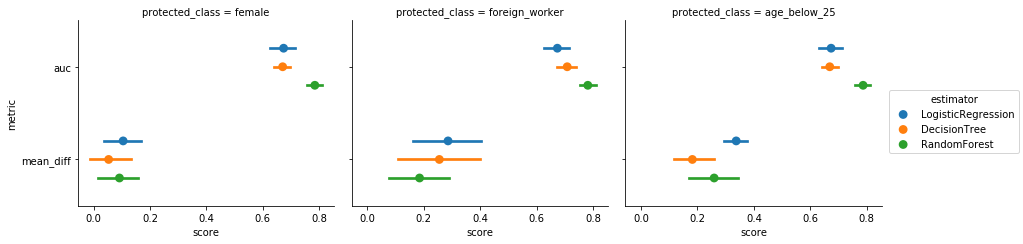

In [198]:
def plot_experiment_results(experiment_results):
    return (
        experiment_results
        .query("fold_type == 'test'")
        .drop(["fold_type", "cv_fold"], axis=1)
        .pipe(pd.melt, id_vars=["protected_class", "estimator"],
              var_name="metric", value_name="score")
        .pipe((sns.factorplot, "data"), y="metric",
              x="score", hue="estimator", col="protected_class", col_wrap=3,
              size=3.5, aspect=1.2, join=False, dodge=0.4))

plot_experiment_results(experiment_baseline);

It appears that the variance of `normalized_mean_difference`
across the 10 cross-validation folds is higher than `mean_difference`,
likely because the normalization factor `d_max` depends on the
rate of positive labels in the data.

In [199]:
from IPython.display import Markdown, display

def print_best_metrics(experiment_results, protected_classes):
    for pclass in protected_classes:
        msg = "#### protected class = %s:" % pclass
        display(Markdown(msg))
        exp_df = experiment_results[
            (experiment_results["protected_class"] == pclass) &
            (experiment_results["fold_type"] == "test")]
        msg = ""
        
        for m in UTILITY_METRICS:
            utility_msg = \
                "- best utility measured by %s (higher is better)" % m
            best_model = (
                exp_df
                .sort_values(m, ascending=False)
                .drop(["fold_type"], axis=1)
                .iloc[0][[m, "estimator"]])
            msg += utility_msg + " = %0.03f: %s\n" % \
                   (best_model[0], best_model[1])
        
        for m in FAIRNESS_METRICS:
            fairness_msg = \
                "- best fairness measured by %s (lower is better)" % m
            best_model = (
                exp_df
                # score closer to zero is better
                .assign(abs_measure=lambda df: df[m].abs())
                .sort_values("abs_measure")
                .drop(["abs_measure", "fold_type"], axis=1)
                .iloc[0][[m, "estimator"]])
            msg += fairness_msg + " = %0.03f: %s\n" % \
                   (best_model[0], best_model[1])
        display(Markdown(msg))
        
print_best_metrics(
    experiment_baseline_summary.reset_index(),
    ["female", "foreign_worker", "age_below_25"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.784: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.054: DecisionTree


#### protected class = foreign_worker:

- best utility measured by auc (higher is better) = 0.782: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.185: RandomForest


#### protected class = age_below_25:

- best utility measured by auc (higher is better) = 0.787: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.182: DecisionTree


# Naive Fairness-aware Approach: Remove Protected Class

The naive approach to training fairness-aware models is to remove the
protected class variables from the input data. While at face value this
approach might seem like a good measure to prevent the model from learning
the discriminatory patterns in the raw data, it doesn't preclude the
possibility of other non-protected class variables highly correlate with
protected class variables.

An well-known example of this is how `zipcode` correlates with `race`, so
`zipcode` essentially serves as a proxy for `race` in the training data
even if `race` is excluded from the input data.

In [200]:
# create feature sets that remove variables with protected class information
feature_set_no_sex = [
    f for f in feature_set_1 if
    f not in [
        'personal_status_and_sex_female_divorced/separated/married',
        'personal_status_and_sex_male_divorced/separated',
        'personal_status_and_sex_male_married/widowed',
        'personal_status_and_sex_male_single']]
feature_set_no_foreign = [f for f in feature_set_1 if f != "foreign_worker"]
feature_set_no_age = [f for f in feature_set_1 if f != "age_in_years"]

In [201]:
# training and target data
X_no_sex = german_credit_preprocessed[feature_set_no_sex].values
X_no_foreign = german_credit_preprocessed[feature_set_no_foreign].values
X_no_age = german_credit_preprocessed[feature_set_no_age].values

experiment_naive_female = cross_validation_experiment(
    estimators, X_no_sex, y, s_female, "female")
experiment_naive_foreign = cross_validation_experiment(
    estimators, X_no_foreign, y, s_foreign, "foreign_worker")
experiment_naive_age_below_25 = cross_validation_experiment(
    estimators, X_no_age, y, s_age_below_25, "age_below_25")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = foreign_worker
-------------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = age_below_25
-----------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 



In [202]:
experiment_naive = pd.concat([
    experiment_naive_female,
    experiment_naive_foreign,
    experiment_naive_age_below_25
])
experiment_naive_summary = summarize_experiment_results(experiment_naive)
experiment_naive_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.704071   0.143313
                LogisticRegression test       0.682381   0.116435
                RandomForest       test       0.783048   0.176268
female          DecisionTree       test       0.689286   0.021054
                LogisticRegression test       0.672238   0.072140
                RandomForest       test       0.787762   0.055187
foreign_worker  DecisionTree       test       0.691476   0.161225
                LogisticRegression test       0.673667   0.284035
                RandomForest       test       0.787286   0.162138

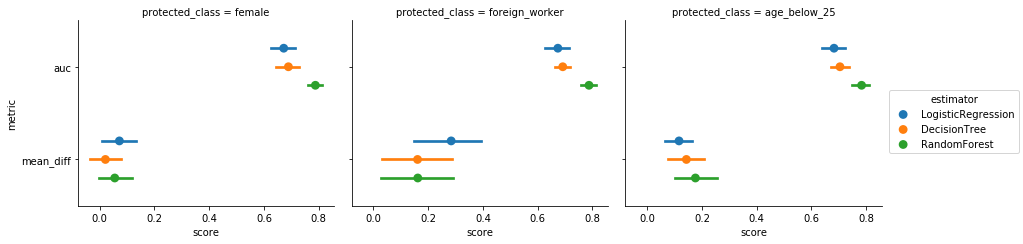

In [203]:
plot_experiment_results(experiment_naive);

In [204]:
print_best_metrics(
    experiment_naive_summary.reset_index(),
    ["female", "foreign_worker", "age_below_25"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.788: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.021: DecisionTree


#### protected class = foreign_worker:

- best utility measured by auc (higher is better) = 0.787: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.161: DecisionTree


#### protected class = age_below_25:

- best utility measured by auc (higher is better) = 0.783: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.116: LogisticRegression


# Fairness-aware Method: Relabelling

In this and the following fairness-aware modeling runs, we exclude the
protected class variables as in the **Naive Fairness-aware Approach**
section in addition to the explicit fairness-aware technique.

In [205]:
from sklearn.base import clone

from themis_ml.preprocessing.relabelling import Relabeller
from themis_ml.meta_estimators import FairnessAwareMetaEstimator

# here we use the relabeller class to create new y vectors for each of the
# protected class contexts.

# we also use the FairnessAwareMetaEstimator as a convenience class to
# compose together different fairness-aware methods. This wraps around the
# estimators that we defined in the previous
relabeller = Relabeller()
relabelling_estimators = [
    (name, FairnessAwareMetaEstimator(e, relabeller=relabeller))
    for name, e in estimators]

experiment_relabel_female = cross_validation_experiment(
    relabelling_estimators, X_no_sex, y, s_female, "female")
experiment_relabel_foreign = cross_validation_experiment(
    relabelling_estimators, X_no_foreign, y, s_foreign, "foreign_worker")
experiment_relabel_age_below_25 = cross_validation_experiment(
    relabelling_estimators, X_no_age, y, s_age_below_25, "age_below_25")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = foreign_worker
-------------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = age_below_25
-----------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 



In [206]:
experiment_relabel = pd.concat([
    experiment_relabel_female,
    experiment_relabel_foreign,
    experiment_relabel_age_below_25
])
experiment_relabel_summary = summarize_experiment_results(experiment_relabel)
experiment_relabel_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.675905   0.085699
                LogisticRegression test       0.676429   0.066849
                RandomForest       test       0.764429   0.070515
female          DecisionTree       test       0.711619   0.046486
                LogisticRegression test       0.669286   0.060313
                RandomForest       test       0.774905   0.055879
foreign_worker  DecisionTree       test       0.652429   0.231549
                LogisticRegression test       0.673619   0.286160
                RandomForest       test       0.790381   0.119456

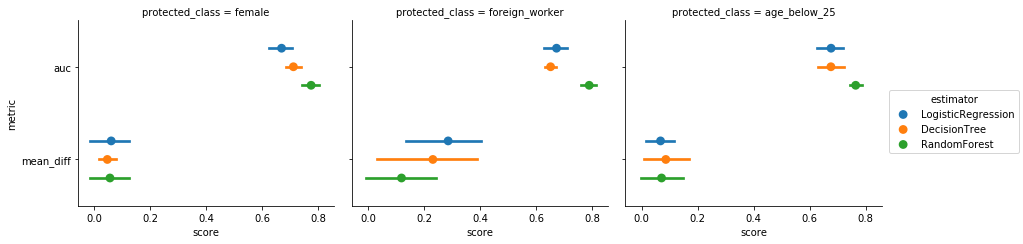

In [207]:
plot_experiment_results(experiment_relabel);

In [208]:
print_best_metrics(
    experiment_relabel_summary.reset_index(),
    ["female", "foreign_worker", "age_below_25"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.775: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.046: DecisionTree


#### protected class = foreign_worker:

- best utility measured by auc (higher is better) = 0.790: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.119: RandomForest


#### protected class = age_below_25:

- best utility measured by auc (higher is better) = 0.764: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.067: LogisticRegression


### Validation Curve: Logistic Regression

In [209]:
LOGREG_L2_PARAM = [
    3, 1, 3e-1, 1e-1, 3e-2, 1e-2, 3e-3, 1e-3,
    3e-4, 1e-4, 3e-5, 1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8]

def validation_curve_experiment(
        estimator_name, estimator, param_name, param_list, update_func):
    validaton_curve_experiment = []
    for param in param_list:
        e = clone(estimator)
        e = update_func(e, param_name, param)
        estimators = [(estimator_name, e)]
        experiment_relabel_female = cross_validation_experiment(
            estimators, X_no_sex, y, s_female, "female",
            verbose=False)
        experiment_relabel_foreign = cross_validation_experiment(
            estimators, X_no_foreign, y, s_foreign, "foreign_worker",
            verbose=False)
        experiment_relabel_age_below_25 = cross_validation_experiment(
            estimators, X_no_age, y, s_age_below_25, "age_below_25",
            verbose=False)
        validaton_curve_experiment.extend(
            [experiment_relabel_female.assign(**{param_name: param}),
             experiment_relabel_foreign.assign(**{param_name: param}),
             experiment_relabel_age_below_25.assign(**{param_name: param})])
    return pd.concat(validaton_curve_experiment)


def update_relabeller(e, param_name, param):
    e = clone(e)
    child_estimator = clone(e.estimator)
    child_estimator.set_params(**{param_name: param})
    e.set_params(estimator=child_estimator)
    return e
        

relabel_validaton_curve_experiment = validation_curve_experiment(
    "LogisticRegression", FairnessAwareMetaEstimator(
        LOGISTIC_REGRESSION, relabeller=Relabeller()),
    "C", LOGREG_L2_PARAM, update_relabeller)

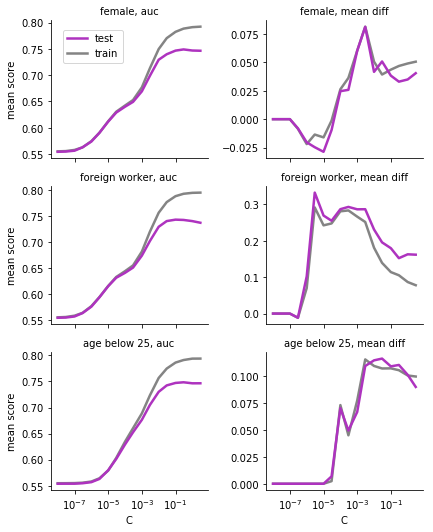

In [210]:
def validation_curve_plot(x, y, **kwargs):
    ax = plt.gca()
    lw = 2.5
    data = kwargs.pop("data")
    train_data = data.query("fold_type == 'train'")
    test_data = data.query("fold_type == 'test'")
    grp_data_train = train_data.groupby(x)
    grp_data_test = test_data.groupby(x)
    mean_data_train = grp_data_train[y].mean()
    mean_data_test = grp_data_test[y].mean()
    std_data_train = grp_data_train[y].std()
    std_data_test = grp_data_test[y].std()
    ax.semilogx(mean_data_train.index, mean_data_train,
                label="train", color="#848484", lw=lw)
    ax.semilogx(mean_data_test.index, mean_data_test,
                label="test", color="#ae33bf", lw=lw)
    # # Add error region
    # ax.fill_between(mean_data_train.index, mean_data_train - std_data_train,
    #                 mean_data_train + std_data_train, alpha=0.2,
    #                 color="darkorange", lw=lw)
    # ax.fill_between(mean_data_test.index, mean_data_test - std_data_test,
    #                 mean_data_test + std_data_test, alpha=0.1,
    #                 color="navy", lw=lw)

relabel_validaton_curve_experiment_df = (
    relabel_validaton_curve_experiment
    .pipe(pd.melt,
          id_vars=["protected_class", "estimator", "cv_fold", "fold_type",
                   "C"],
          value_vars=["auc", "mean_diff"],
          var_name="metric", value_name="score")
    .assign(
        protected_class=lambda df: df.protected_class.str.replace("_", " "),
        metric=lambda df: df.metric.str.replace("_", " "))
    .rename(columns={"score": "mean score"})
)

# relabel_validaton_curve_experiment_df
g = sns.FacetGrid(
    relabel_validaton_curve_experiment_df,
    row="protected_class",
    col="metric", size=2.5, aspect=1.1, sharey=False,
    margin_titles=False)
g = g.map_dataframe(validation_curve_plot, "C", "mean score")
g.set_titles(template="{row_name}, {col_name}")
# g.add_legend()
# g.add_legend(bbox_to_anchor=(0.275, 0.91))
g.add_legend(bbox_to_anchor=(0.28, 0.9))
g.fig.tight_layout()
g.savefig("IMG/logistic_regression_validation_curve.png");

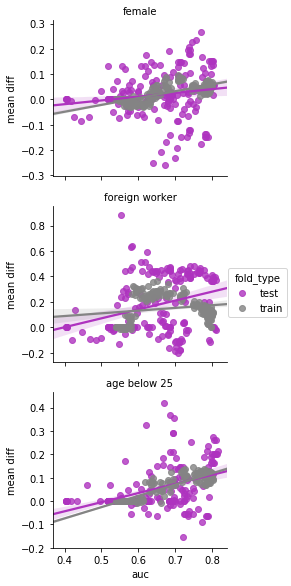

In [254]:
def utility_fairness_corr_plot(x, y, **kwargs):
    ax = plt.gca()
    lw = 2
    data = kwargs.pop("data").sort_values(x)
    data.plot(x, y, ax=ax, kind="scatter", alpha=0.5)

corr_plot = (
    relabel_validaton_curve_experiment_df
    .pivot_table(
        index=["protected_class", "estimator", "cv_fold", "fold_type","C"],
        columns="metric", values="mean score")
    .reset_index()
)

train_test_palette = sns.color_palette(["#ae33bf", "#848484"])

g = sns.FacetGrid(
    corr_plot,
    row="protected_class",
    row_order=["female", "foreign worker", "age below 25"],
    hue="fold_type", size=2.75, aspect=1.25, sharey=False,
    hue_order=["test", "train"],
    margin_titles=False,
    palette=train_test_palette)
(
    g
    .map(sns.regplot, "auc", "mean diff")
    .set_titles(row_template="{row_name}")
    .add_legend()
#     .add_legend(title="", bbox_to_anchor=(0.95, 0.5))
);
g.savefig("IMG/logistic_regression_fairness_utility_tradeoff.png");

# Fairness-aware Method: Additive Counterfactually Fair Model

In [212]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from themis_ml.linear_model.counterfactually_fair_models import \
    LinearACFClassifier

LINEAR_REG = LinearRegression()
DECISION_TREE_REG = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)
RANDOM_FOREST_REG = RandomForestRegressor(
    n_estimators=50, max_depth=10, min_samples_leaf=10)

# use the estimators defined above to define the linear additive
# counterfactually fair models
linear_acf_estimators = [
    (name, LinearACFClassifier(
         target_estimator=e,
         binary_residual_type="absolute"))
    for name, e in estimators]

experiment_acf_female = cross_validation_experiment(
    linear_acf_estimators, X_no_sex, y, s_female, "female")
experiment_acf_foreign = cross_validation_experiment(
    linear_acf_estimators, X_no_foreign, y, s_foreign, "foreign_worker")
experiment_acf_age_below_25 = cross_validation_experiment(
    linear_acf_estimators, X_no_age, y, s_age_below_25, "age_below_25")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = foreign_worker
-------------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = age_below_25
-----------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 



In [213]:
experiment_acf = pd.concat([
    experiment_acf_female,
    experiment_acf_foreign,
    experiment_acf_age_below_25
])
experiment_acf_summary = summarize_experiment_results(experiment_acf)
experiment_acf_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.710048   0.220084
                LogisticRegression test       0.666381  -0.022842
                RandomForest       test       0.787524   0.374574
female          DecisionTree       test       0.702429   0.167098
                LogisticRegression test       0.668810   0.043642
                RandomForest       test       0.789000   0.134816
foreign_worker  DecisionTree       test       0.675952   0.444736
                LogisticRegression test       0.665190   0.138082
                RandomForest       test       0.786952   0.326778

In [214]:
experiment_acf = pd.concat([
    experiment_acf_female,
    experiment_acf_foreign,
    experiment_acf_age_below_25
])
experiment_acf_summary = summarize_experiment_results(experiment_acf)
experiment_acf_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.710048   0.220084
                LogisticRegression test       0.666381  -0.022842
                RandomForest       test       0.787524   0.374574
female          DecisionTree       test       0.702429   0.167098
                LogisticRegression test       0.668810   0.043642
                RandomForest       test       0.789000   0.134816
foreign_worker  DecisionTree       test       0.675952   0.444736
                LogisticRegression test       0.665190   0.138082
                RandomForest       test       0.786952   0.326778

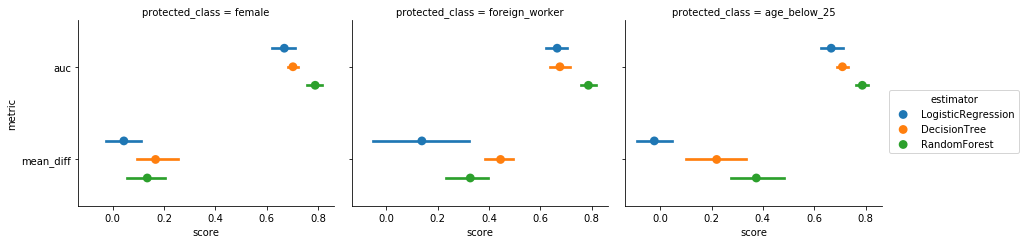

In [215]:
plot_experiment_results(experiment_acf);

In [216]:
print_best_metrics(
    experiment_acf_summary.reset_index(),
    ["female", "foreign_worker", "age_below_25"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.789: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.044: LogisticRegression


#### protected class = foreign_worker:

- best utility measured by auc (higher is better) = 0.787: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.138: LogisticRegression


#### protected class = age_below_25:

- best utility measured by auc (higher is better) = 0.788: RandomForest
- best fairness measured by mean_diff (lower is better) = -0.023: LogisticRegression


# Fairness-aware Method: Reject-option Classification

In [217]:
from themis_ml.postprocessing.reject_option_classification import \
    SingleROClassifier

# use the estimators defined above to define the linear additive
# counterfactually fair models
single_roc_clf_estimators = [
    (name, SingleROClassifier(estimator=e))
    for name, e in estimators]

experiment_single_roc_female = cross_validation_experiment(
    single_roc_clf_estimators, X_no_sex, y, s_female, "female")
experiment_single_roc_foreign = cross_validation_experiment(
    single_roc_clf_estimators, X_no_foreign, y, s_foreign, "foreign_worker")
experiment_single_roc_age_below_25 = cross_validation_experiment(
    single_roc_clf_estimators, X_no_age, y, s_age_below_25, "age_below_25")

Training models: protected_class = female
-----------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = foreign_worker
-------------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 

Training models: protected_class = age_below_25
-----------------------------------------------
LogisticRegression, fold: 0 1 2 3 4 5 6 7 8 9 
DecisionTree, fold: 0 1 2 3 4 5 6 7 8 9 
RandomForest, fold: 0 1 2 3 4 5 6 7 8 9 



In [218]:
experiment_single_roc = pd.concat([
    experiment_single_roc_female,
    experiment_single_roc_foreign,
    experiment_single_roc_age_below_25
])
experiment_single_roc_summary = summarize_experiment_results(
    experiment_single_roc)
experiment_single_roc_summary.query("fold_type == 'test'")

auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.694786   0.081250
                LogisticRegression test       0.539905  -0.047437
                RandomForest       test       0.767143   0.129876
female          DecisionTree       test       0.690024  -0.022866
                LogisticRegression test       0.608524  -0.049494
                RandomForest       test       0.761048   0.011103
foreign_worker  DecisionTree       test       0.674762   0.133963
                LogisticRegression test       0.619429   0.032667
                RandomForest       test       0.761381   0.140321

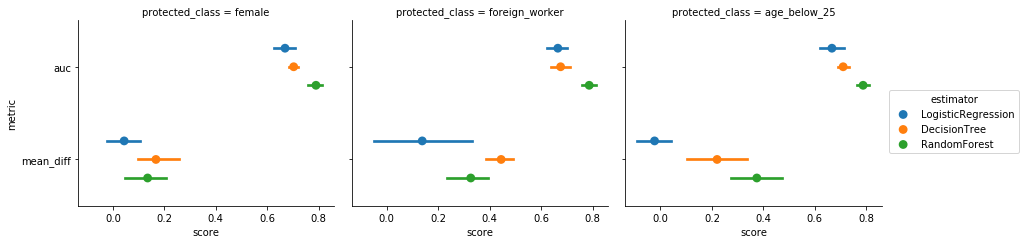

In [219]:
plot_experiment_results(experiment_acf);

In [220]:
print_best_metrics(
    experiment_acf.reset_index(),
    ["female", "foreign_worker", "age_below_25"])

#### protected class = female:

- best utility measured by auc (higher is better) = 0.861: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.015: DecisionTree


#### protected class = foreign_worker:

- best utility measured by auc (higher is better) = 0.842: RandomForest
- best fairness measured by mean_diff (lower is better) = -0.082: LogisticRegression


#### protected class = age_below_25:

- best utility measured by auc (higher is better) = 0.841: RandomForest
- best fairness measured by mean_diff (lower is better) = 0.024: DecisionTree


# Comparison of Fairness-aware Techniques

In [368]:
compare_experiments = (
    pd.concat([
        experiment_baseline.assign(experiment="B"),
        experiment_naive.assign(experiment="RPA"),
        experiment_relabel.assign(experiment="RTV"),
        experiment_acf.assign(experiment="CFM"),
        experiment_single_roc.assign(experiment="ROC")
    ])
    .assign(
        protected_class=lambda df: df.protected_class.str.replace("_", " "),
    )
)
compare_experiments.head()

,protected_class,estimator,cv_fold,fold_type,auc,mean_diff,experiment
0,female,LogisticRegression,0,train,0.676490,0.094124,B
1,female,LogisticRegression,0,test,0.742857,0.261905,B
2,female,LogisticRegression,1,train,0.683892,0.090553,B
3,female,LogisticRegression,1,test,0.624286,0.119048,B
4,female,LogisticRegression,2,train,0.678025,0.115808,B


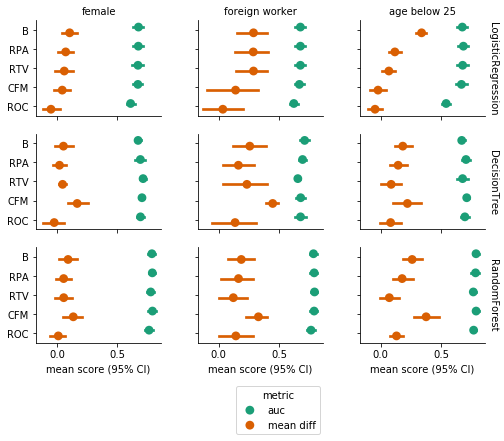

In [385]:
comparison_palette = sns.color_palette("Dark2", n_colors=8)

def compare_experiment_results_multiple_model(experiment_results):
    g = (
        experiment_results
        .query("fold_type == 'test'")
        .drop(["cv_fold"], axis=1)
        .pipe(pd.melt, id_vars=["experiment", "protected_class", "estimator",
                                "fold_type"],
              var_name="metric", value_name="score")
        .assign(
            metric=lambda df: df.metric.str.replace("_", " "))
        .pipe((sns.factorplot, "data"), y="experiment",
              x="score", hue="metric",
              col="protected_class", row="estimator",
              join=False, size=1.8, aspect=1.35, dodge=0.3,
              palette=comparison_palette, margin_titles=True, legend=False))
    g.set_axis_labels("mean score (95% CI)")
    for ax in g.axes.ravel():
        ax.set_ylabel("")
        plt.setp(ax.texts, text="")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    plt.legend(title="metric", loc=9, bbox_to_anchor=(-0.65, -0.4))
#     g.fig.legend(loc=9, bbox_to_anchor=(0.5, -0.3))
#     g.fig.tight_layout()
    g.savefig("IMG/fairness_aware_comparison.png", dpi=500);

compare_experiment_results_multiple_model(compare_experiments);

We can make some interesting observations when comparing the results from different fairness-aware techniques.

In [370]:
from scipy import stats

def compute_corr_pearson(x, y, ci=0.95):
    corr = stats.pearsonr(x, y)
    z = np.arctanh(corr[0])
    sigma = (1 / ((len(x) - 3) ** 0.5))
    cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1 + ci ) / 2)
    return corr, np.tanh(cint)

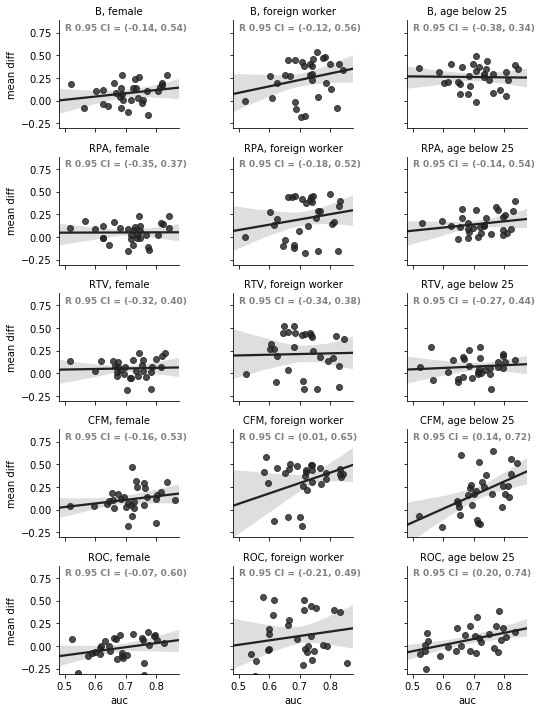

In [384]:
black_palette = sns.color_palette(["#222222"])

def plot_utility_fairness_tradeoff(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    sns_ax = sns.regplot(x=x, y=y, data=data, **kwargs)
    (corr, p_val), ci = compute_corr_pearson(data[x], data[y])
    r_text = 'R 0.95 CI = (%0.02f, %0.02f)' % \
        (ci[0], ci[1])
    sns_ax.annotate(
        r_text, xy=(0.7, 0),
        xytext=(0.05, 0.91),
        textcoords='axes fraction',
        fontweight="bold",
        fontsize=9,
        color="gray"
    )
    bottom_padding = 0.05
    top_padding = 0.5
    ylim = (data[y].min() - bottom_padding, data[y].max() + top_padding)
    sns_ax.set_ylim(*ylim)


g = sns.FacetGrid(
    (
        compare_experiments
        .drop("cv_fold", axis=1)
        .reset_index()
        .query("fold_type == 'test'")
        .rename(
            columns={"mean_diff": "mean diff"})
    ),
    col="protected_class",
    row="experiment",
    hue="experiment",
    size=2.0, aspect=1.3, sharey=True,
    palette=black_palette)
g.map_dataframe(plot_utility_fairness_tradeoff, "auc", "mean diff")
g.set_titles(template="{row_name}, {col_name}")
g.fig.tight_layout()
g.savefig("IMG/fairness_utility_tradeoff.png", dpi=500);